<h1> Write my own loss function

In [1]:
# own skrips
import helperfile as hf
# generalls libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
import keras.backend as k

In [2]:
rootfile = uproot.open('./stage4_clusters_big.root')
ipd = hf.InputData_2photon(rootfile, sort_cond='none',min_dist=4)
ipd.form_cluster()
ipd.train_test_split()
ipd.prep_trainingsdata()
ipd.prep_verificationdata()

Initialized object
Cutted  436821  clusters due to photon pair with distance smaller than  4  cm.
Start shaping clusters in a  (9, 9)  grid...
Shaping the clusters took  108.16164207458496 s
Splitted data into training and test set!
Prepared 'veri_truth' data
Prepared 'veri_fit' data (Lednev fit from coral)


In [3]:
def loss_flip(y_true, y_pred):
    mse = k.sum(k.square(y_true - y_pred), axis=1)
    y_pred_flipped = tf.roll(y_pred, 3, axis=1)
    mse_flipped = k.sum(k.square(y_true - y_pred_flipped), axis=1)
    vec = tf.stack([mse, mse_flipped], axis=1)
    loss = k.min(vec, axis=1)
    return loss

In [4]:
#model = keras.models.load_model('./models/model_st4_custom_loss_min_dis_4cm', custom_objects={'loss_flip': loss_flip} )
#output = model.predict(ipd.clusters_v)
#ev = hf.Evaluation_2photon(ipd, output)

In [5]:
#fit_v_Lednev = ev.show_hist_NN_withLednev(figsave=(False, "custom_loss_&_4cm_minimum_distance"))

In [6]:
#fit_v= ev.show_hist_NN(figsave=(False, "custom_loss_&_4cm_minimum_distance"), r_x=(-7,7))

ok...did something go wrong?

In [7]:
model1 = keras.Sequential([layers.Input(shape=(81)), \
                         layers.Normalization(mean=2.5, variance=13.4), \
                         layers.Dense(128, activation="relu"), \
                         layers.Dense(256, activation="relu"), \
                         layers.Dense(512, activation="relu"), \
                         layers.Dense(256, activation="relu"), \
                         layers.Dense(128, activation="relu"), \
                         layers.Dense(64, activation="relu"), \
                         layers.Dense(6, activation=None)])
model1.summary()
model1.compile(loss=loss_flip, optimizer=Adam(learning_rate=0.0001))

print("Start training the network with ", len(ipd.clusters_t), " clusters...")
a = time.time()
fit_hist = model1.fit(ipd.clusters_t, ipd.training, batch_size=64, epochs=200, validation_split=0.1)
b = time.time()
print('This took ', (b-a)/60 , ' min.')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 81)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               10496     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8

5053/5053 [==============================] - 8s 2ms/step - loss: 106.5851 - val_loss: 140.1401
Epoch 64/200
5053/5053 [==============================] - 8s 2ms/step - loss: 105.7239 - val_loss: 151.4965
Epoch 65/200
5053/5053 [==============================] - 8s 2ms/step - loss: 105.3098 - val_loss: 147.5213
Epoch 66/200
5053/5053 [==============================] - 8s 2ms/step - loss: 104.2274 - val_loss: 146.1947
Epoch 67/200
5053/5053 [==============================] - 8s 2ms/step - loss: 102.6953 - val_loss: 135.2731
Epoch 68/200
5053/5053 [==============================] - 8s 2ms/step - loss: 102.2307 - val_loss: 153.2973
Epoch 69/200
5053/5053 [==============================] - 8s 2ms/step - loss: 100.7138 - val_loss: 144.3179
Epoch 70/200
5053/5053 [==============================] - 8s 2ms/step - loss: 100.2812 - val_loss: 144.1752
Epoch 71/200
5053/5053 [==============================] - 8s 2ms/step - loss: 99.7093 - val_loss: 156.2228
Epoch 72/200
5053/5053 [==================

5053/5053 [==============================] - 8s 2ms/step - loss: 64.5782 - val_loss: 129.0915
Epoch 140/200
5053/5053 [==============================] - 8s 1ms/step - loss: 65.5792 - val_loss: 132.8682
Epoch 141/200
5053/5053 [==============================] - 7s 1ms/step - loss: 63.9456 - val_loss: 130.3896
Epoch 142/200
5053/5053 [==============================] - 8s 2ms/step - loss: 64.4267 - val_loss: 134.5706
Epoch 143/200
5053/5053 [==============================] - 8s 2ms/step - loss: 64.0414 - val_loss: 131.0848
Epoch 144/200
5053/5053 [==============================] - 7s 1ms/step - loss: 63.3024 - val_loss: 129.6888
Epoch 145/200
5053/5053 [==============================] - 7s 1ms/step - loss: 63.0352 - val_loss: 128.5880
Epoch 146/200
5053/5053 [==============================] - 8s 2ms/step - loss: 62.8508 - val_loss: 130.7310
Epoch 147/200
5053/5053 [==============================] - 7s 1ms/step - loss: 63.4196 - val_loss: 126.7679
Epoch 148/200
5053/5053 [=================

In [8]:
(b-a)/60 

25.789836577574413

In [9]:
title = "st4_custom_loss_min_dis_4cm"

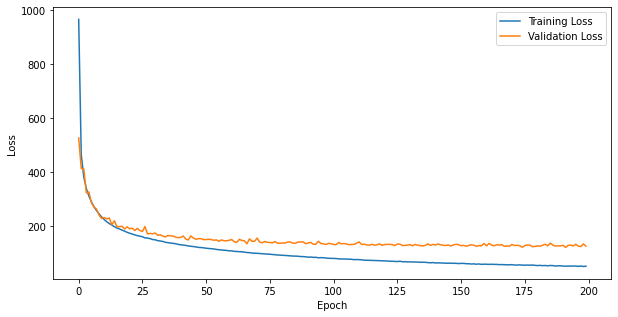

In [10]:
output1 = model1.predict(ipd.clusters_v)
output_flipped = np.roll(output1, 3, axis=1)
mse = np.mean(np.square(output1-ipd.veri_truth), axis=1)
mse_flipped = np.mean(np.square(output_flipped-ipd.veri_truth), axis=1)

ind_flip = np.where(mse_flipped<mse)
output1[ind_flip] = np.roll(output1[ind_flip], 3, axis=1)
ev1 = hf.Evaluation_2photon(ipd, output1)

plt.rcParams["figure.figsize"] = (10,5)
ev1.training_vs_validation_loss(fit_hist, save=False, title=title) # save loss functions

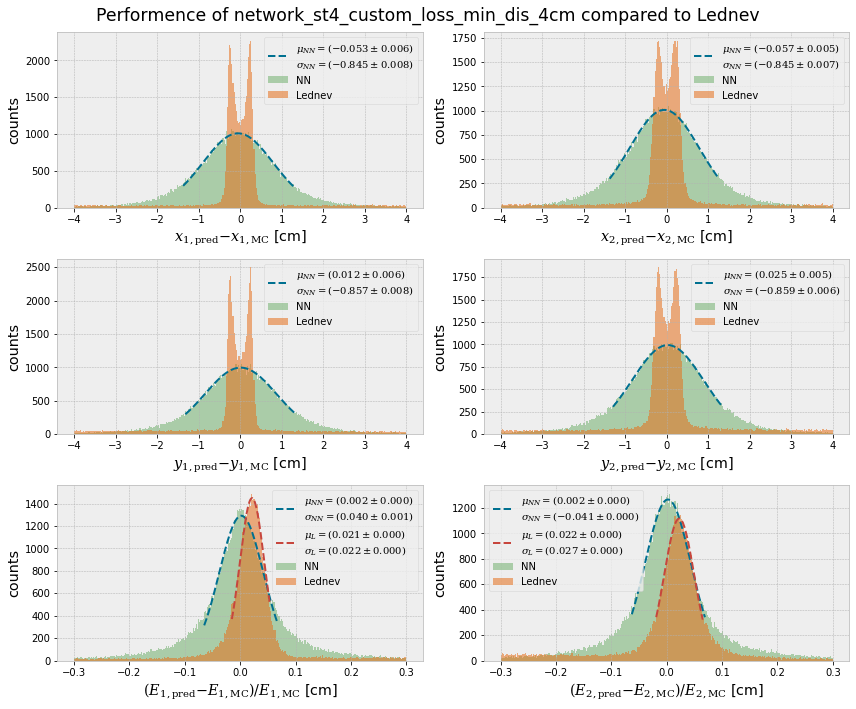

In [11]:
fit_param = ev1.show_hist_NN_withLednev(figsave=(False, "network_" + title))

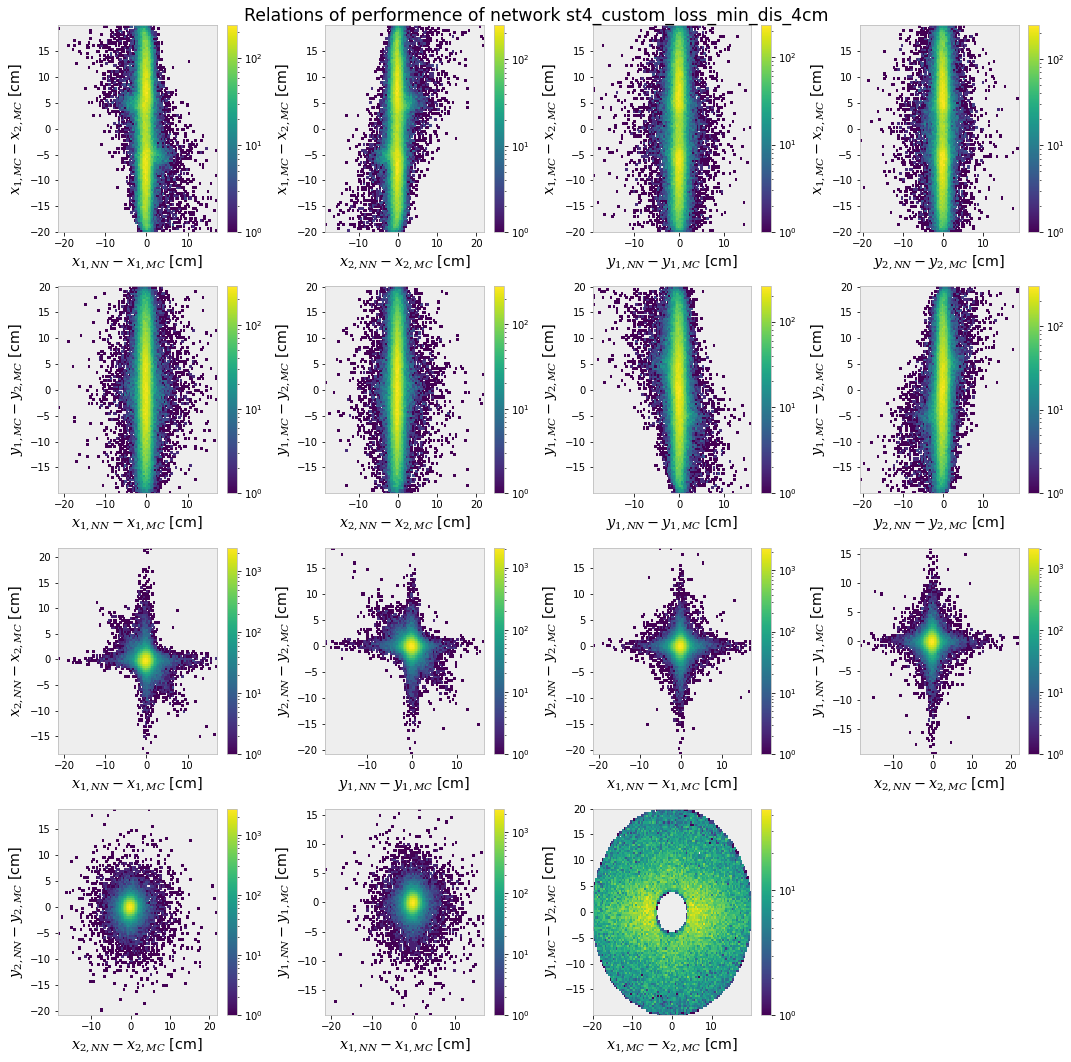

In [12]:
ev1.show_2d_hist(figsave=False, title=title)

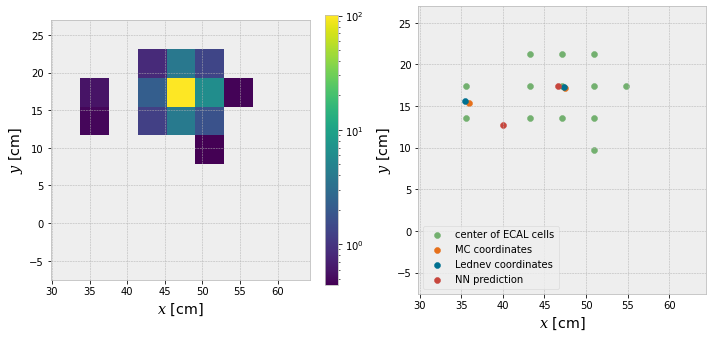

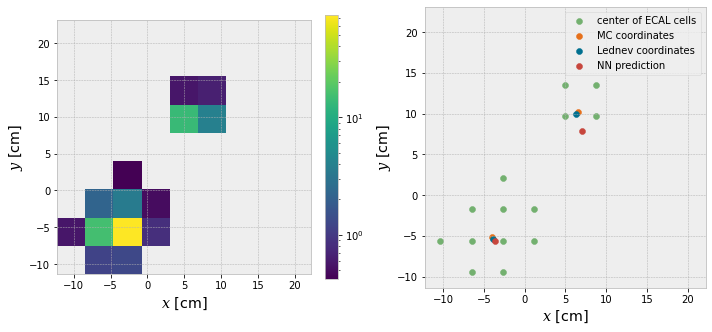

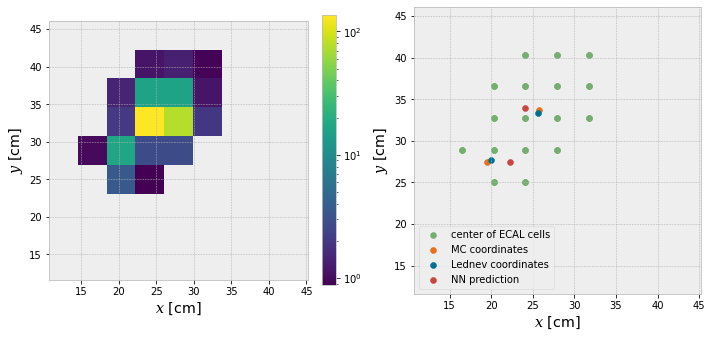

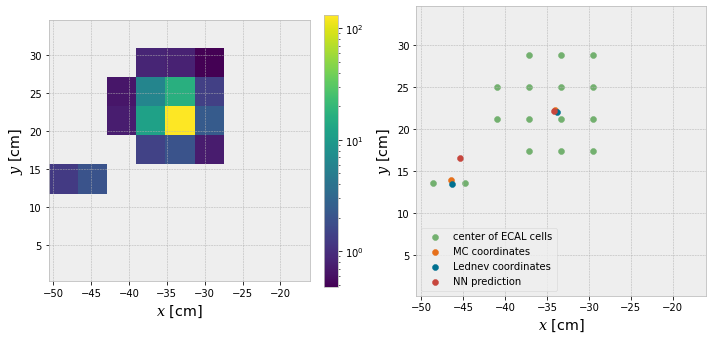

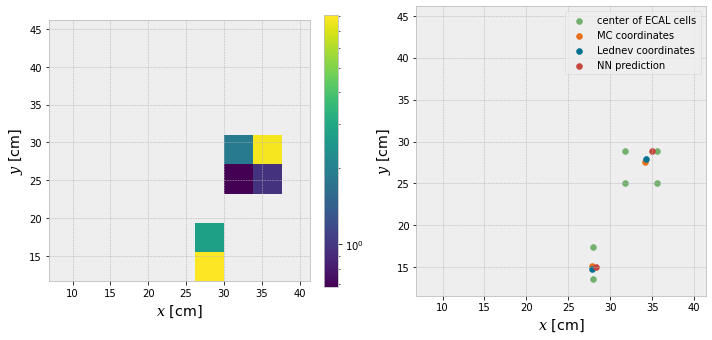

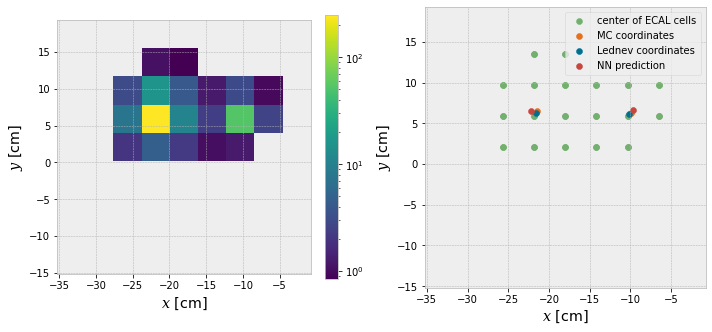

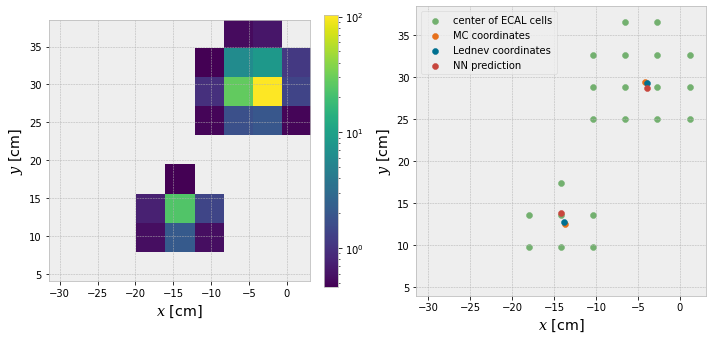

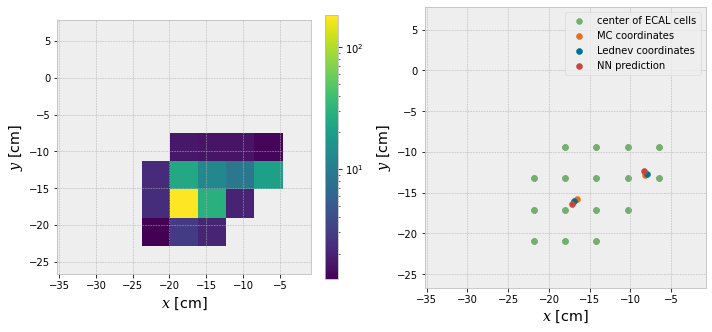

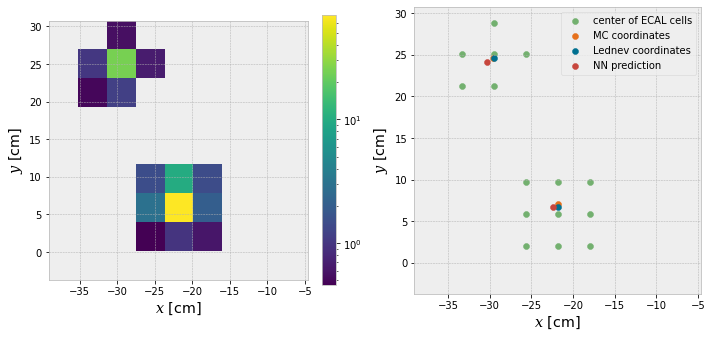

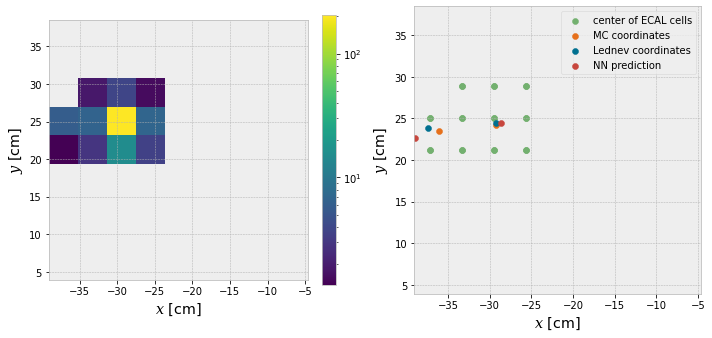

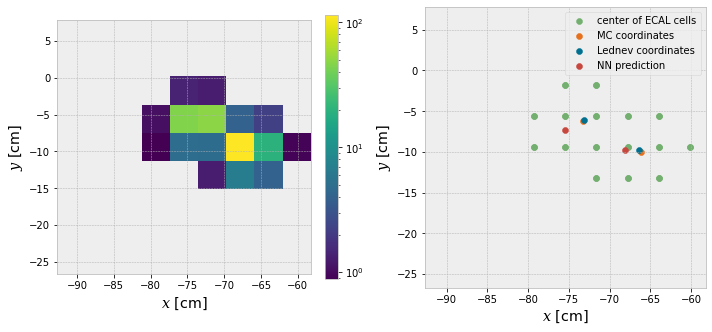

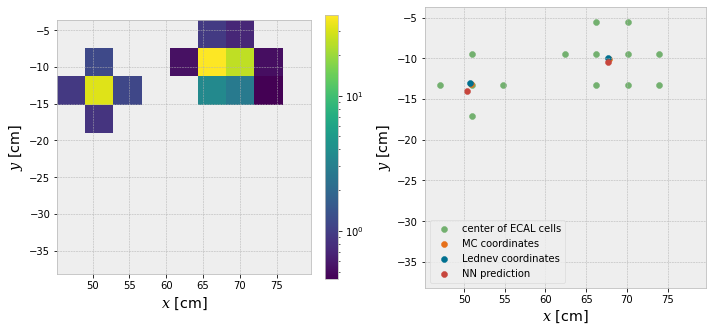

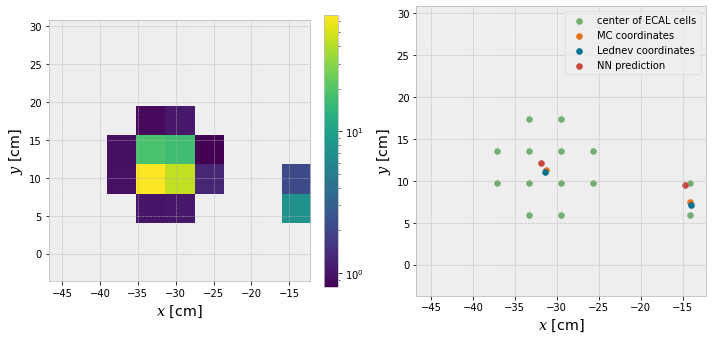

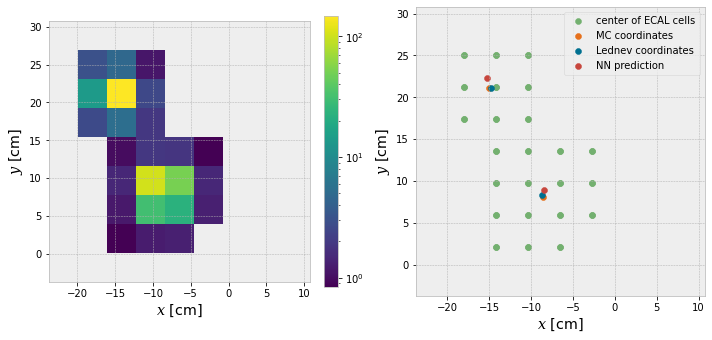

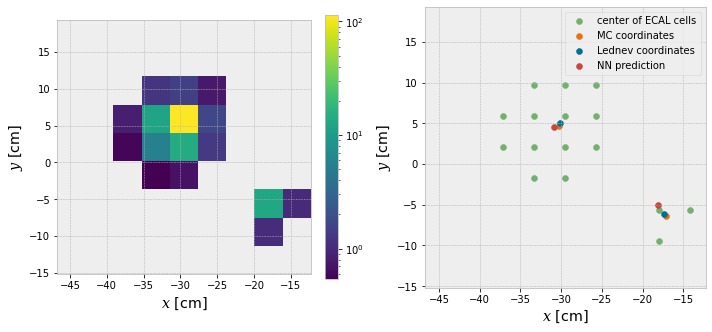

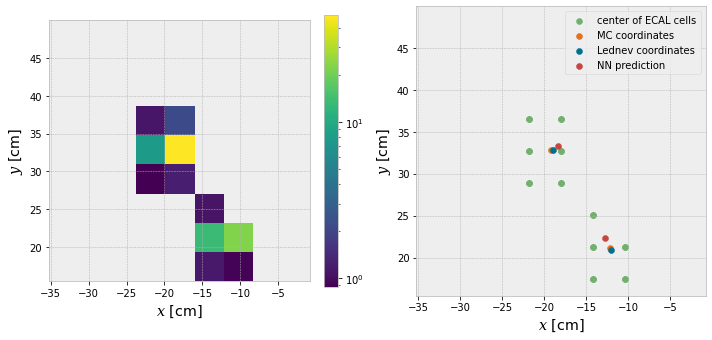

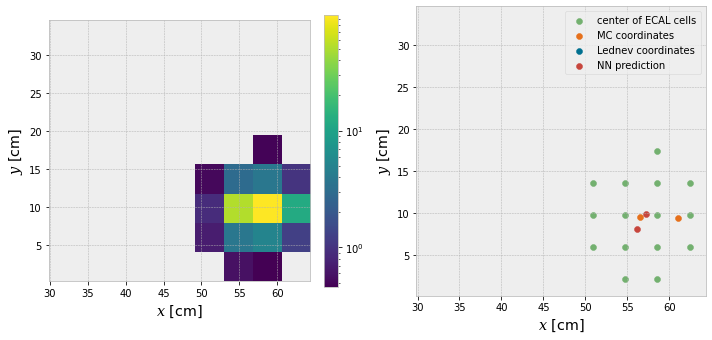

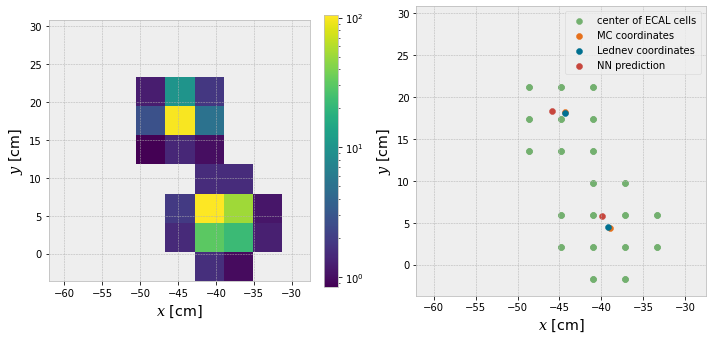

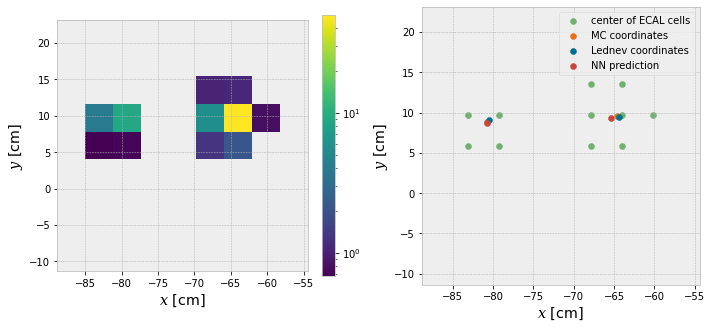

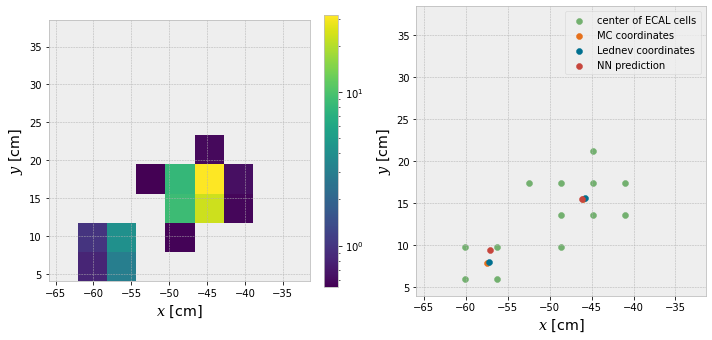

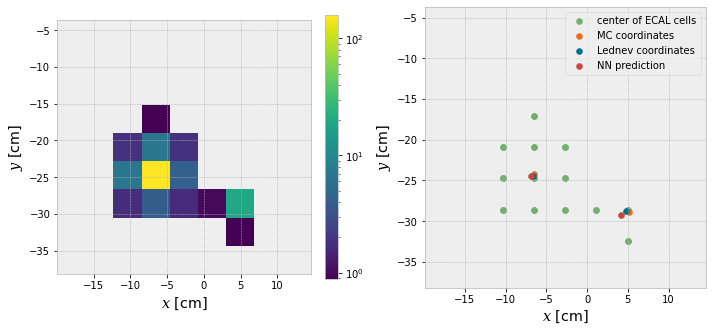

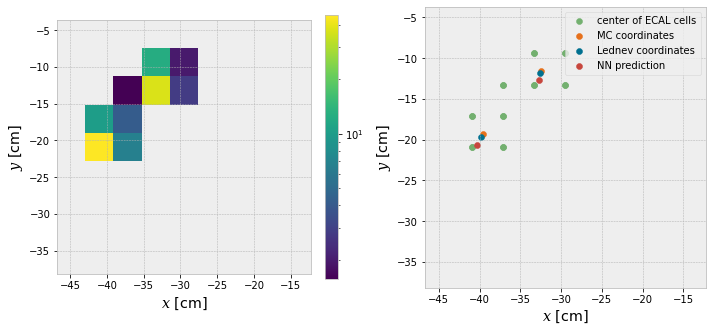

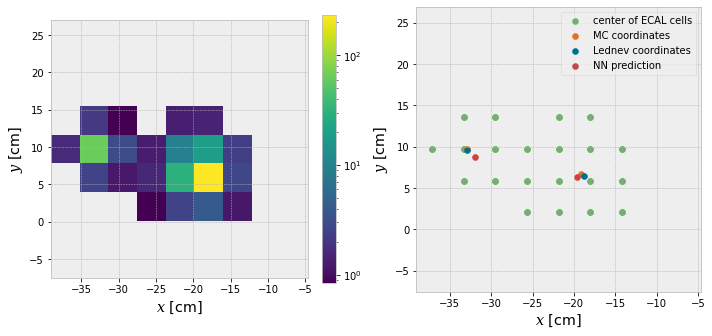

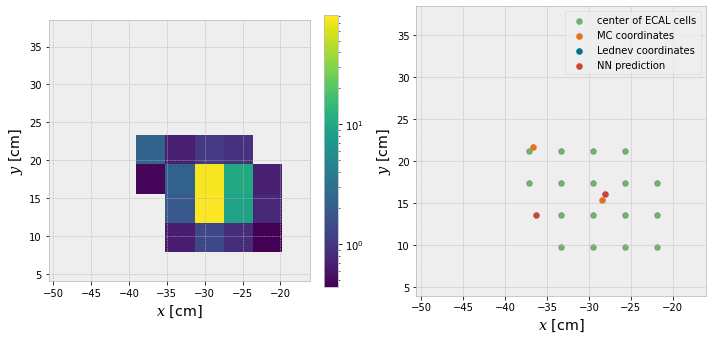

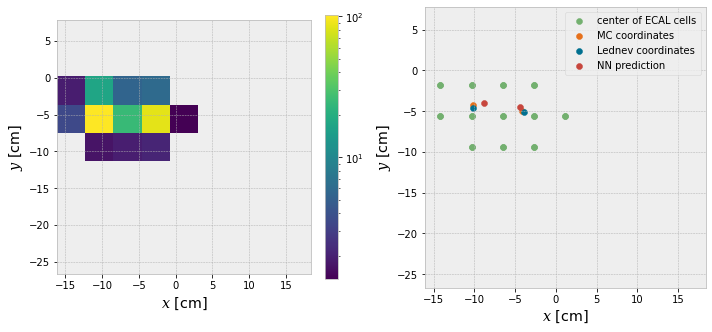

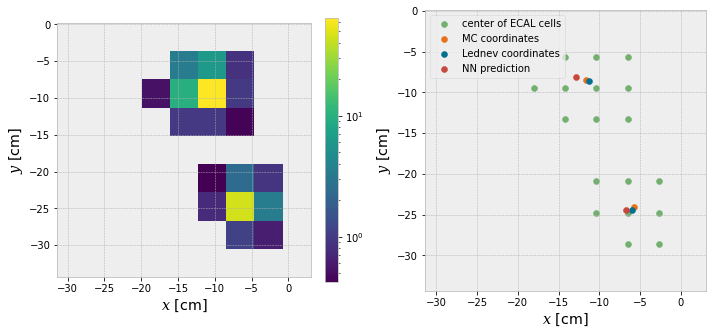

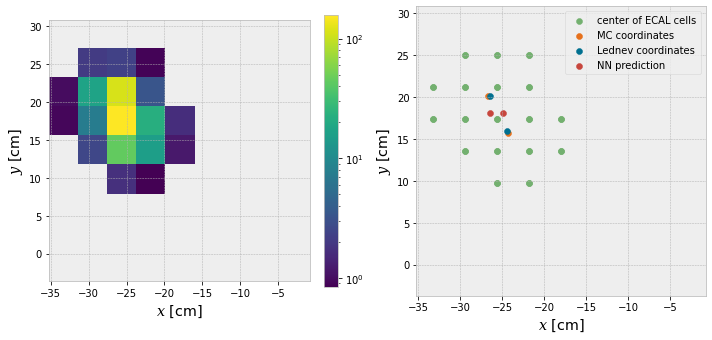

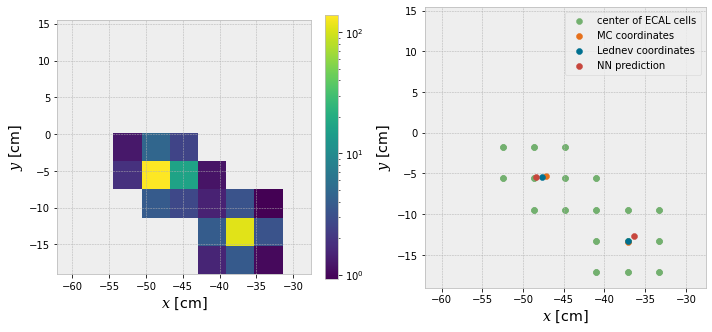

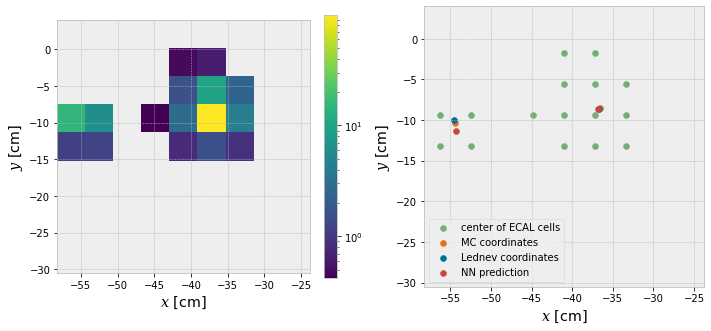

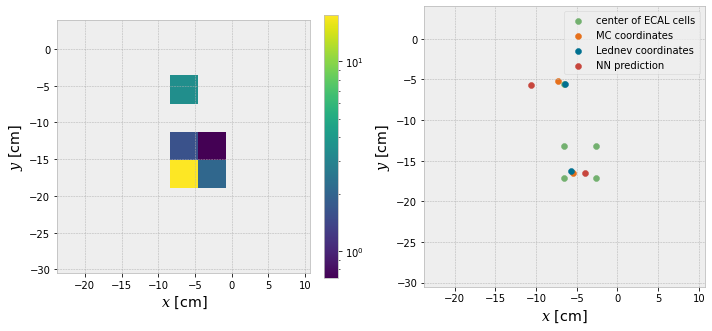

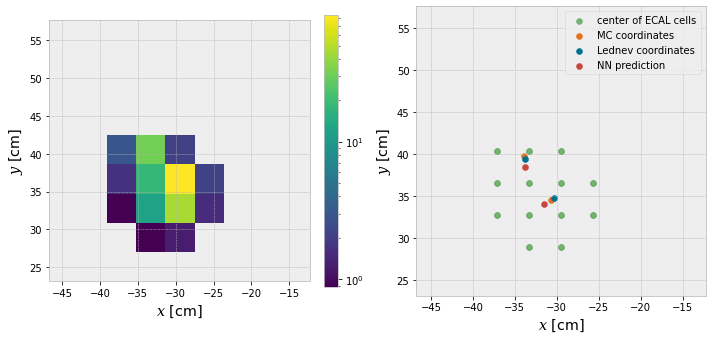

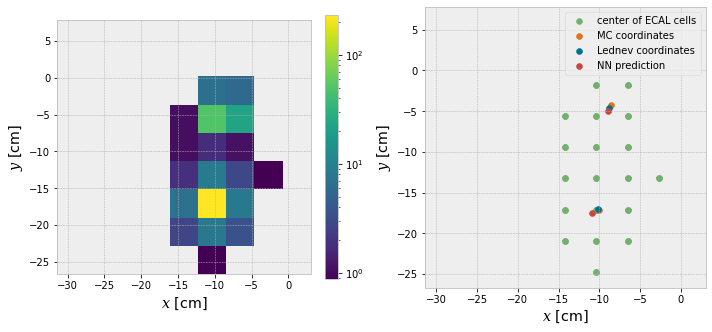

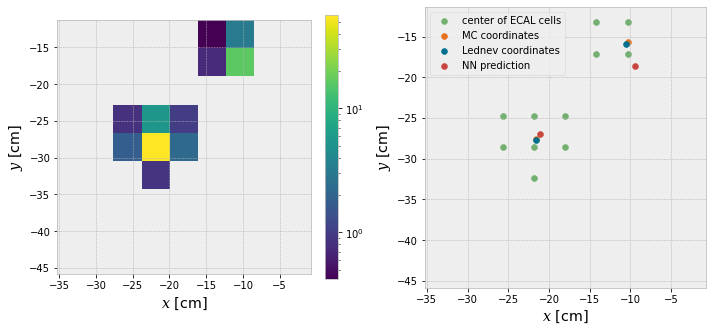

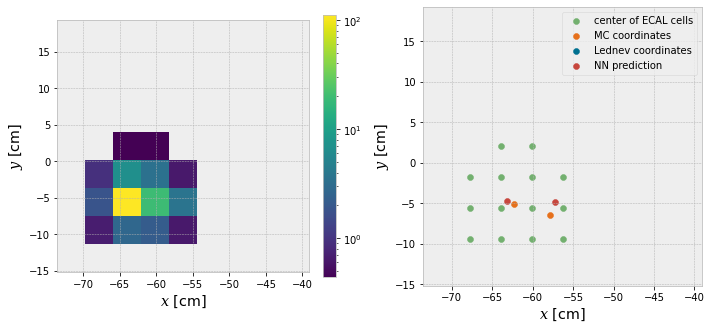

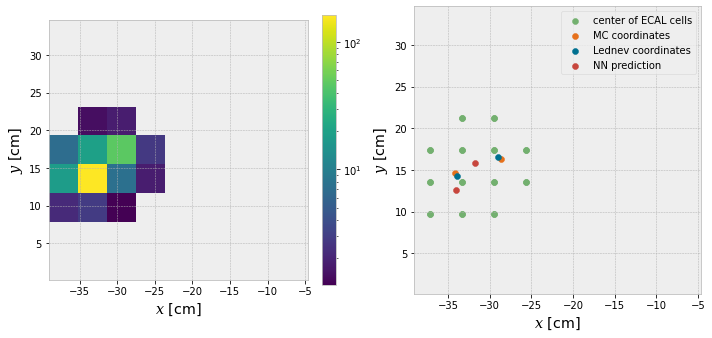

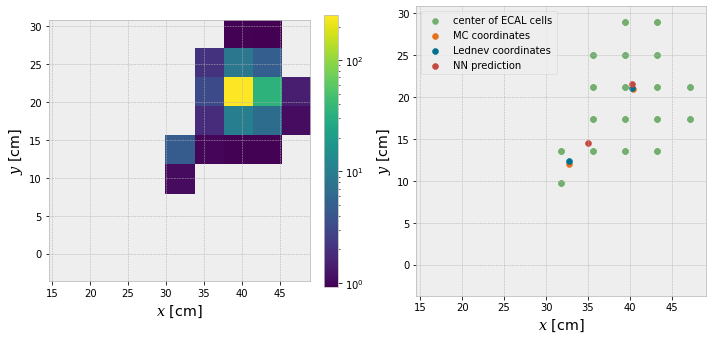

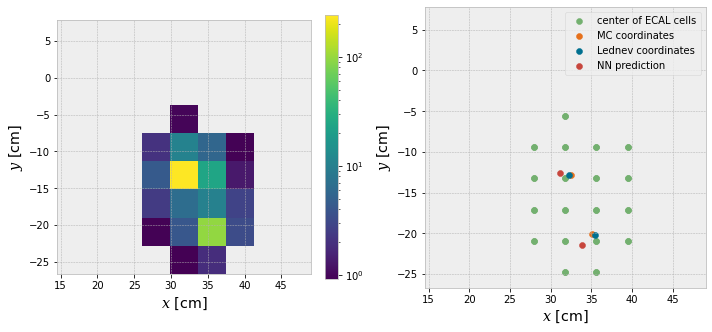

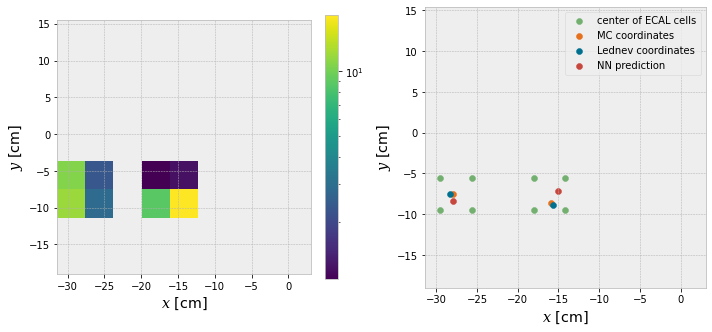

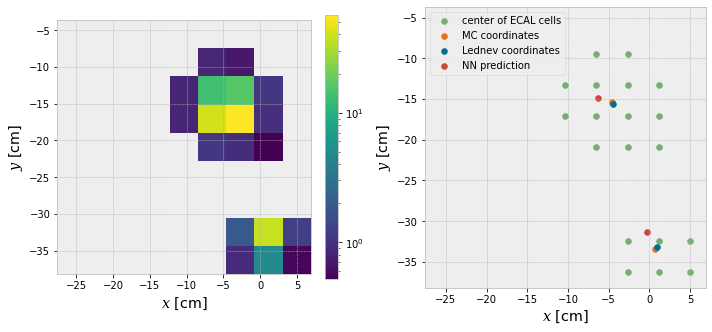

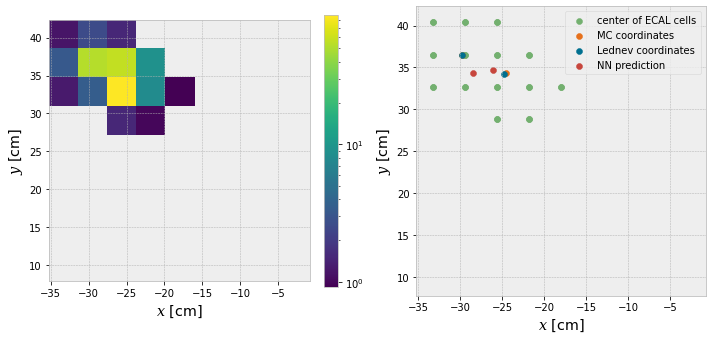

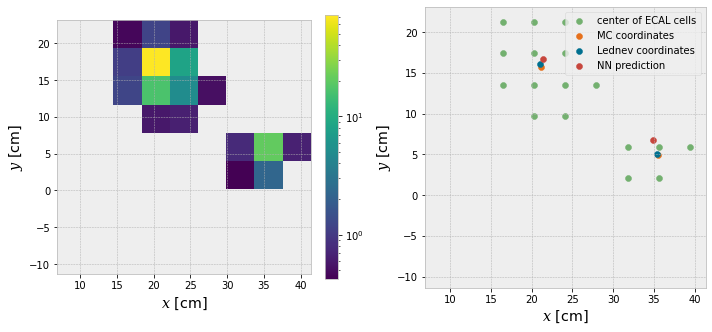

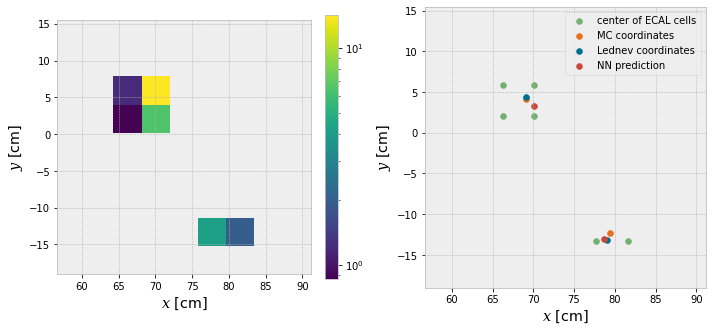

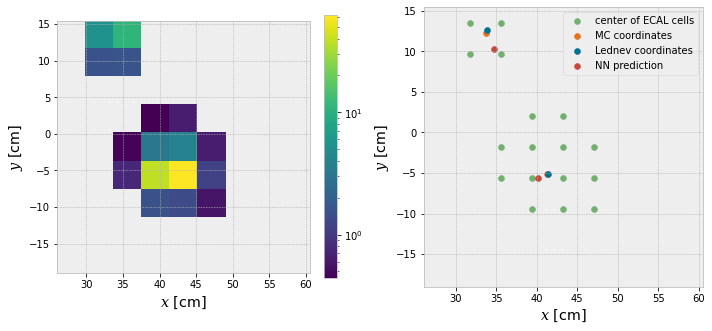

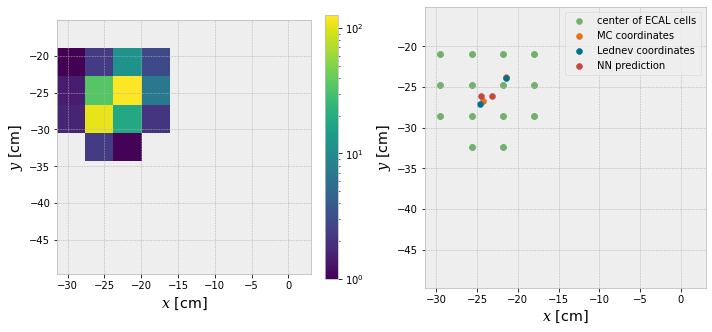

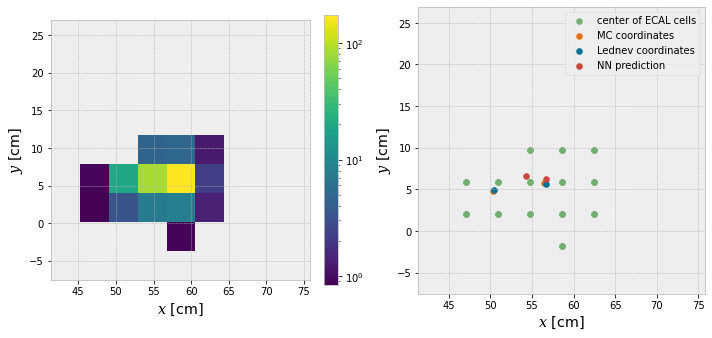

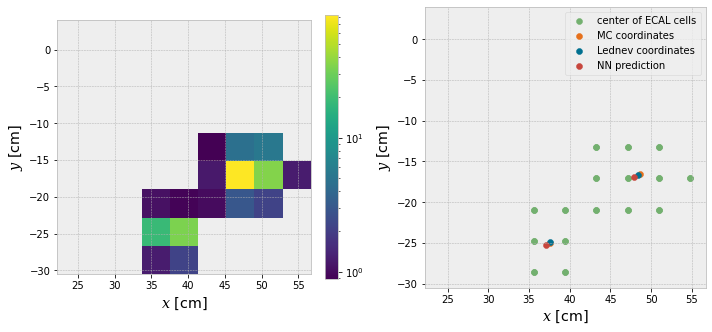

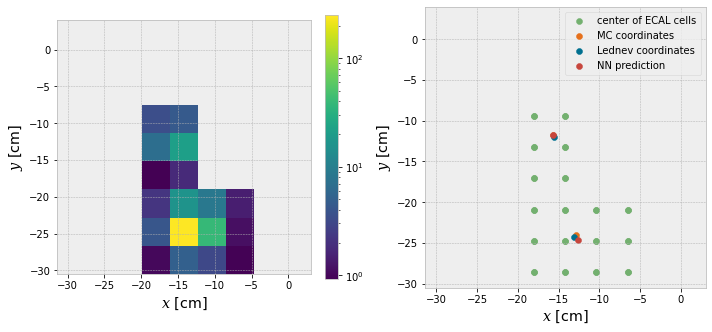

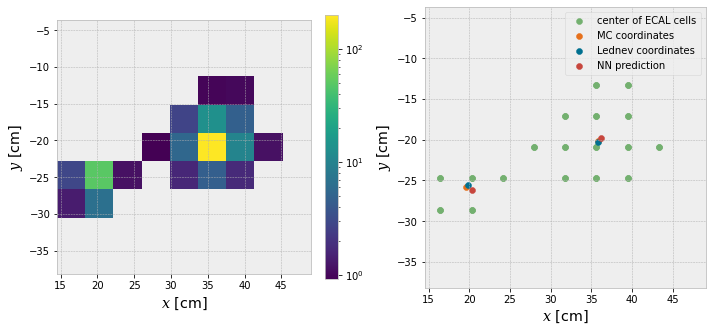

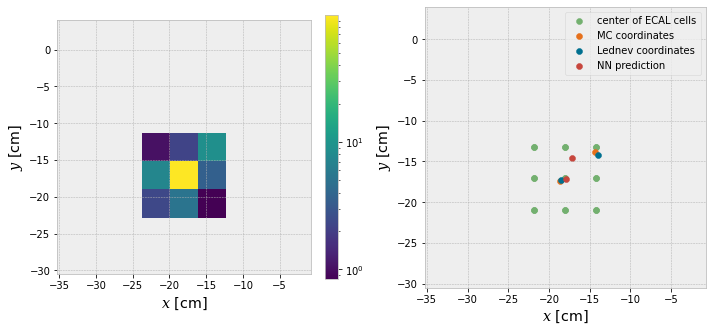

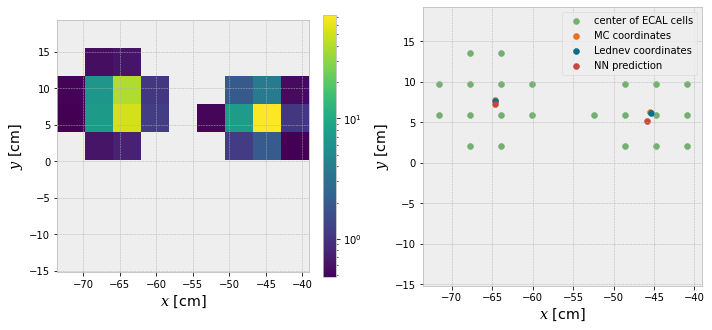

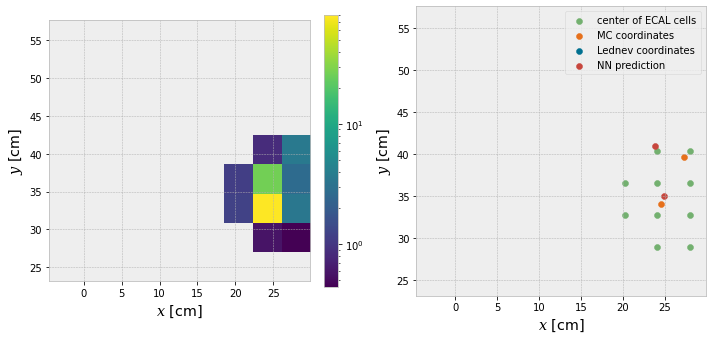

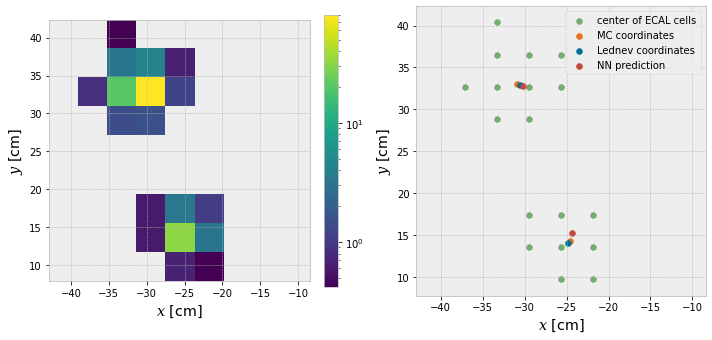

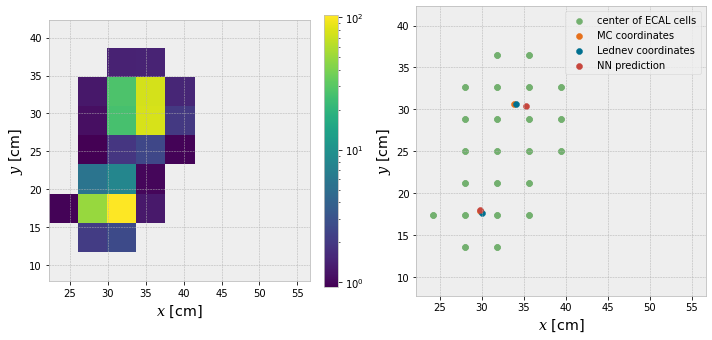

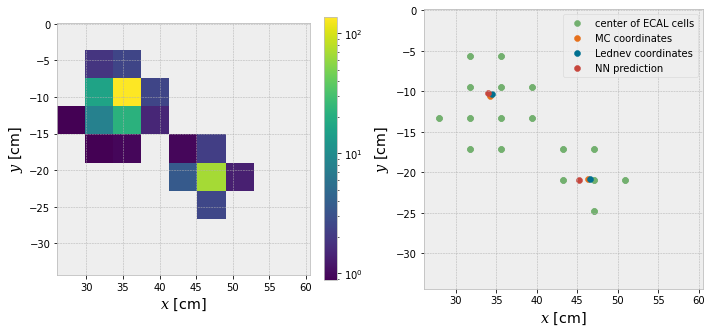

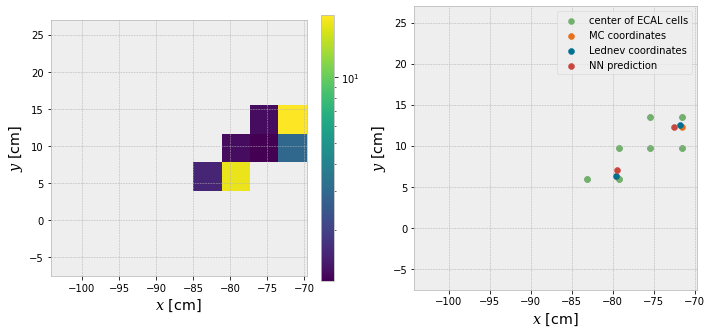

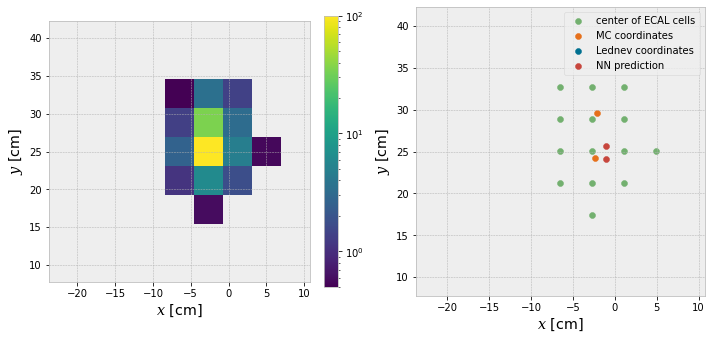

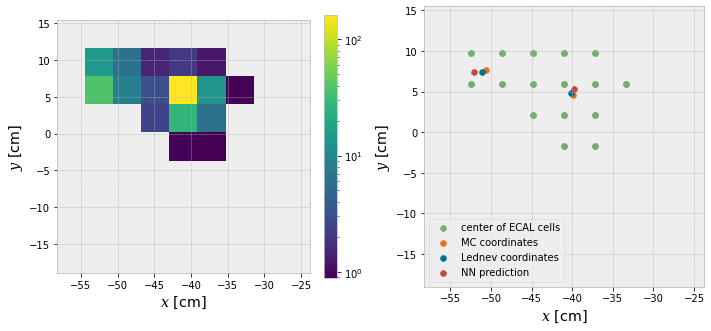

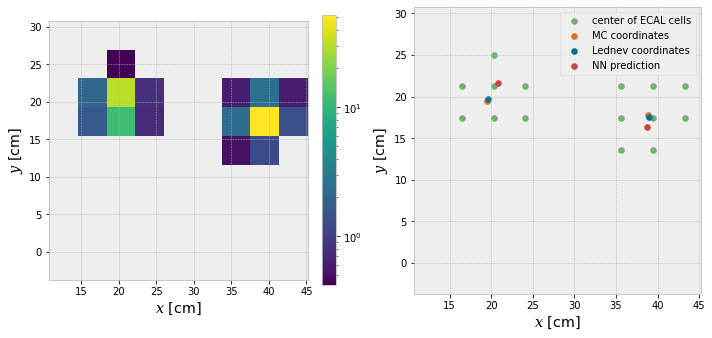

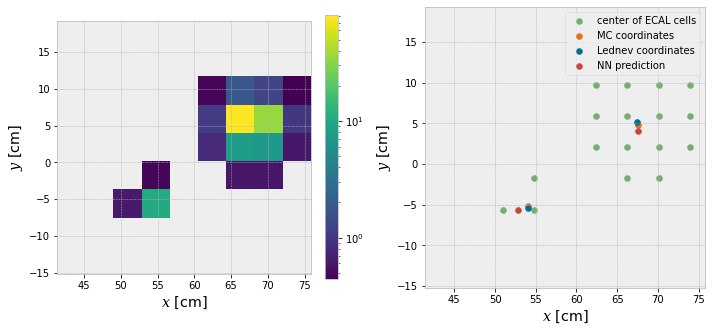

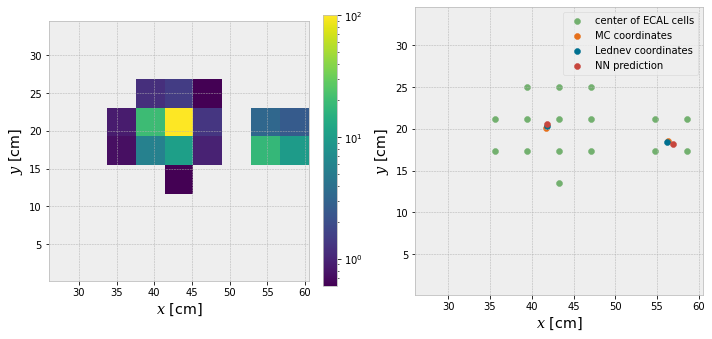

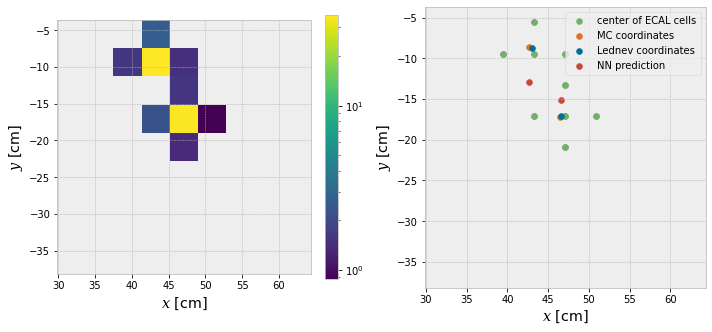

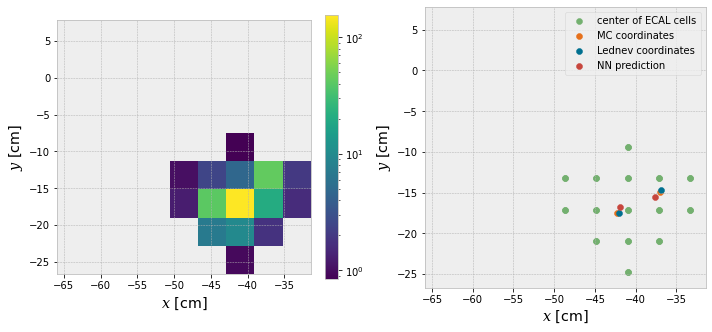

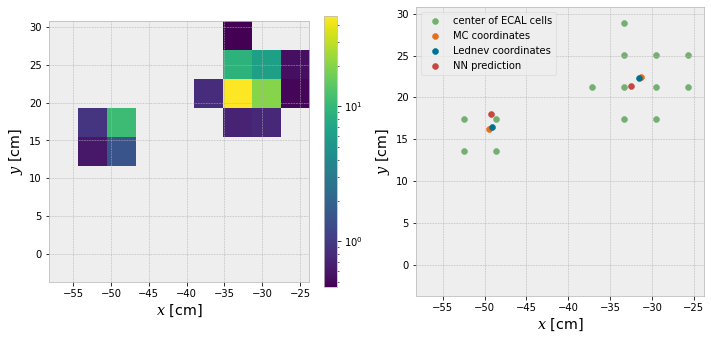

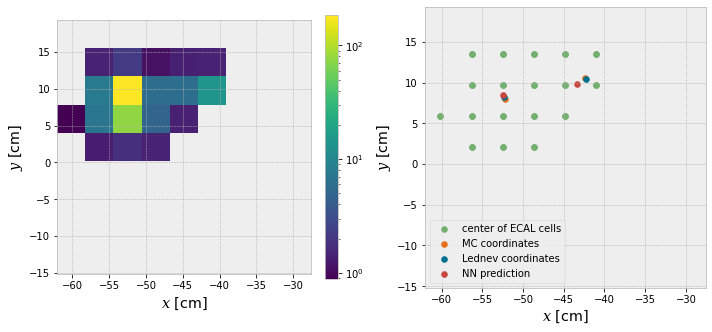

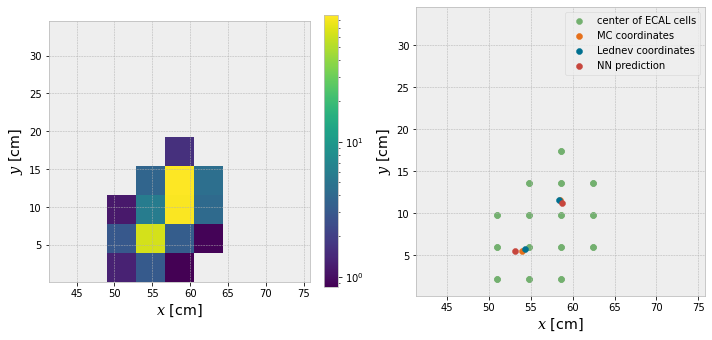

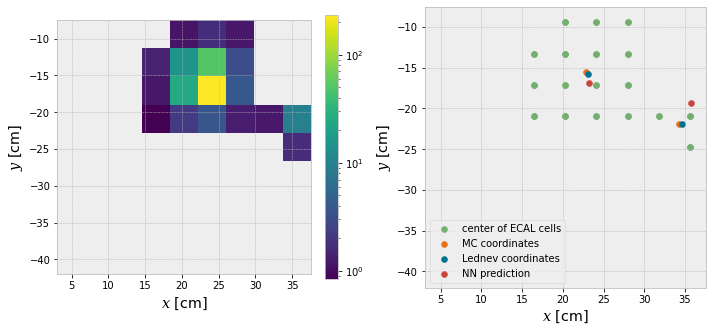

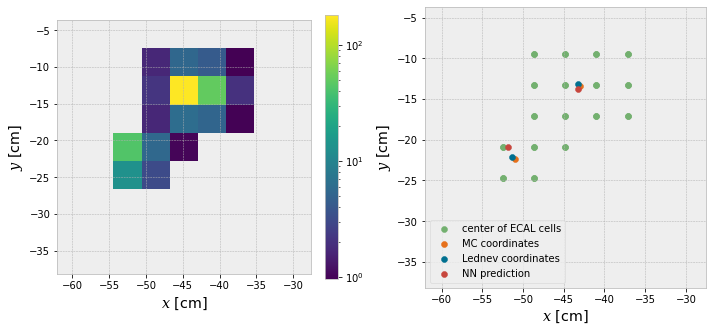

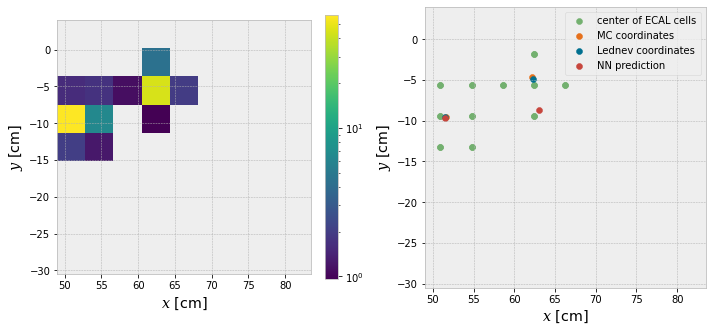

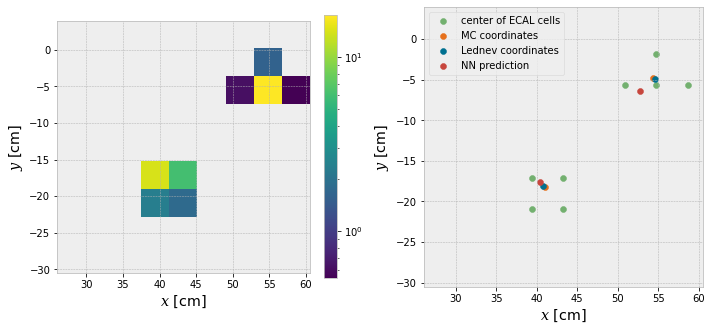

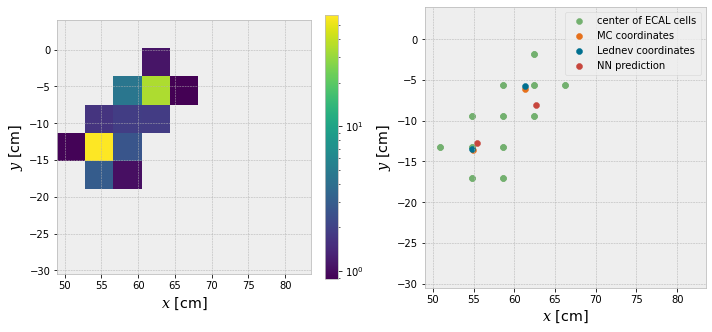

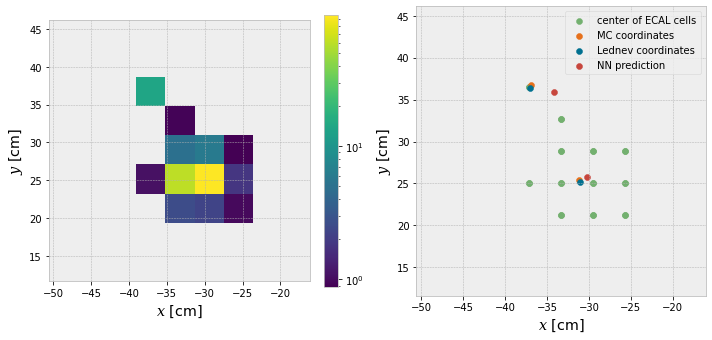

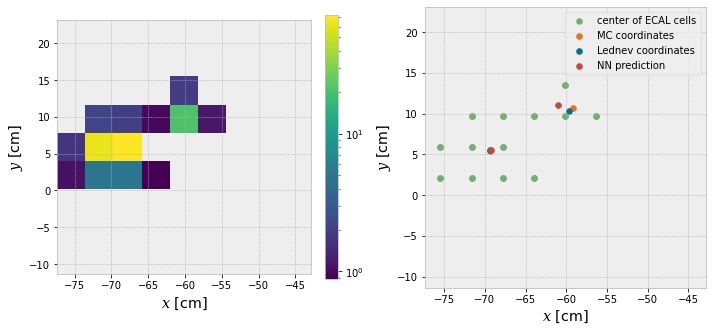

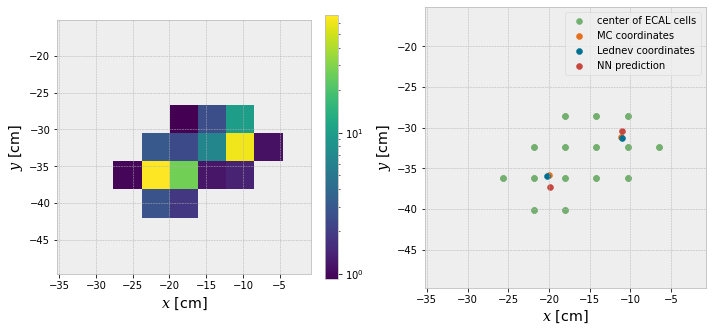

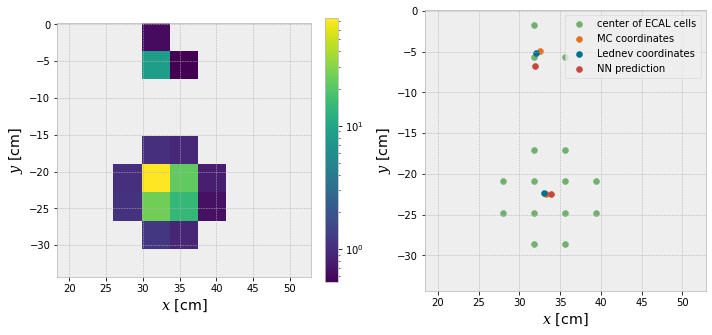

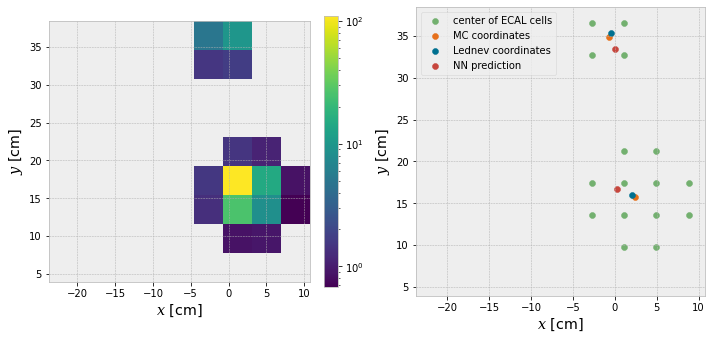

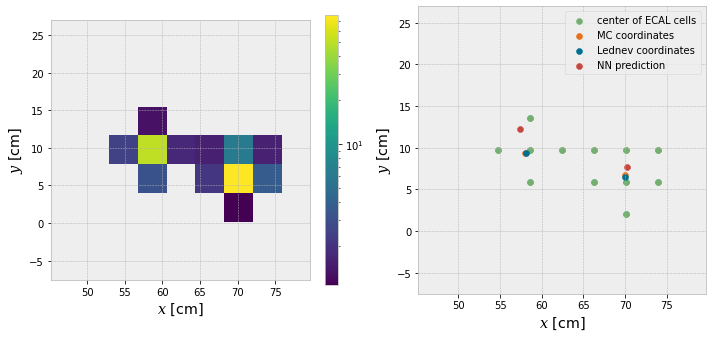

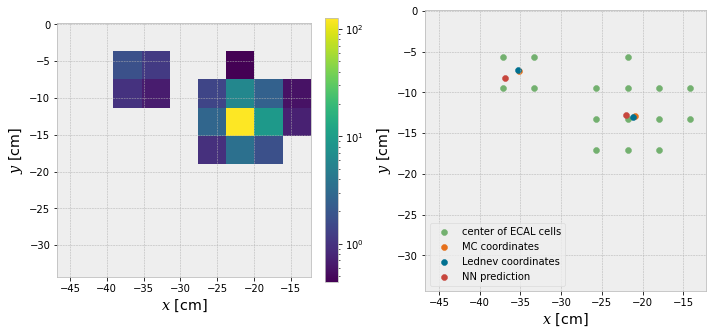

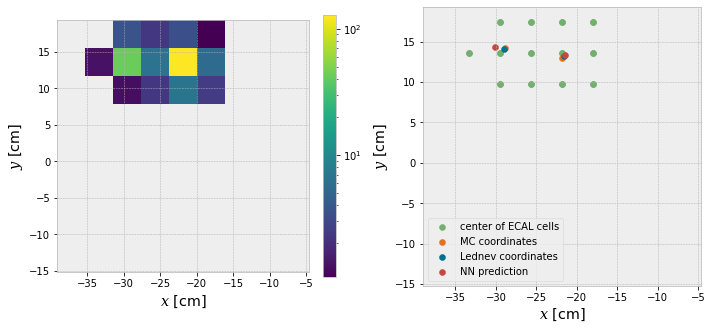

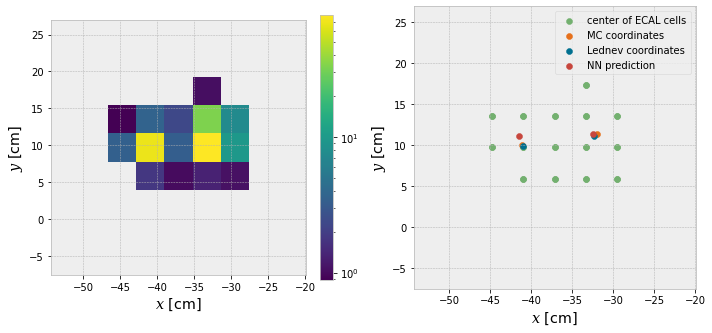

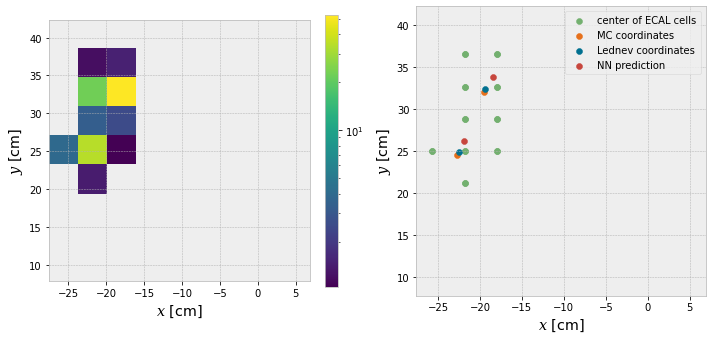

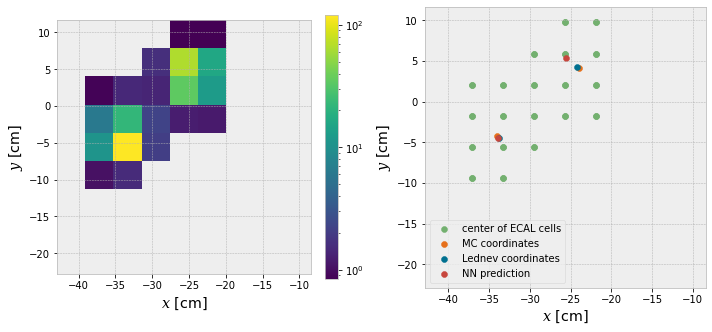

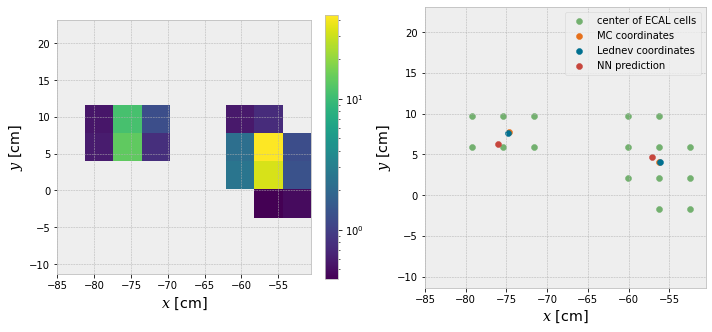

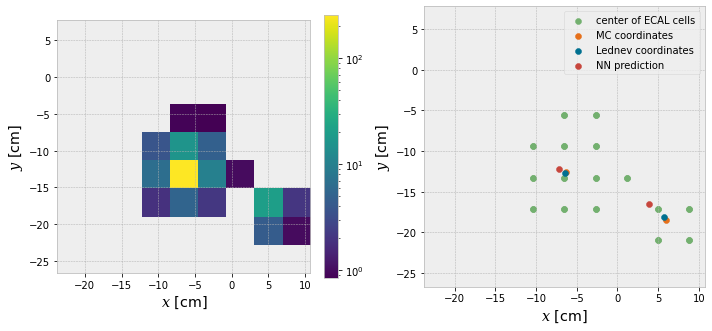

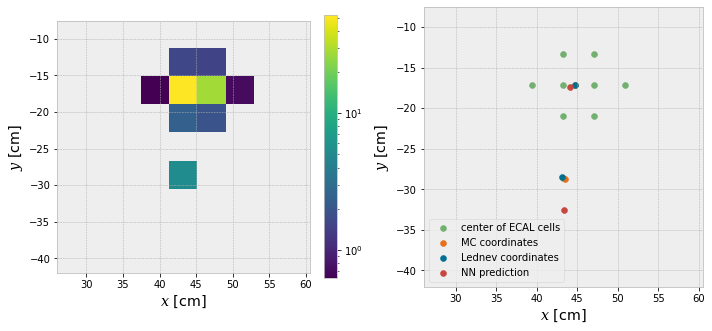

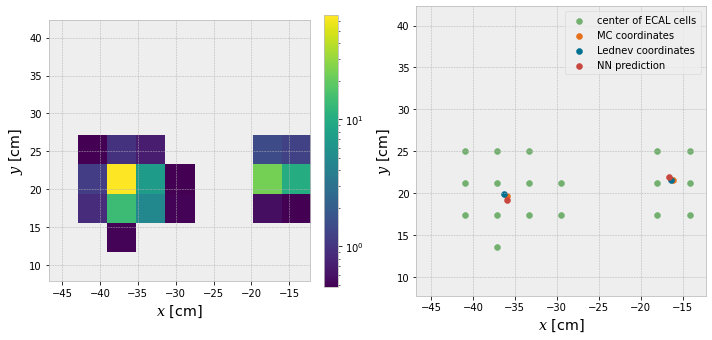

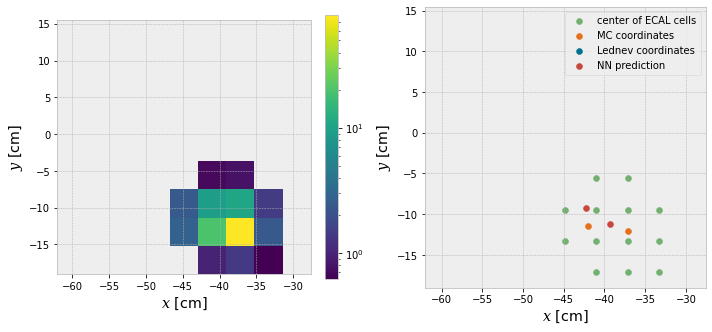

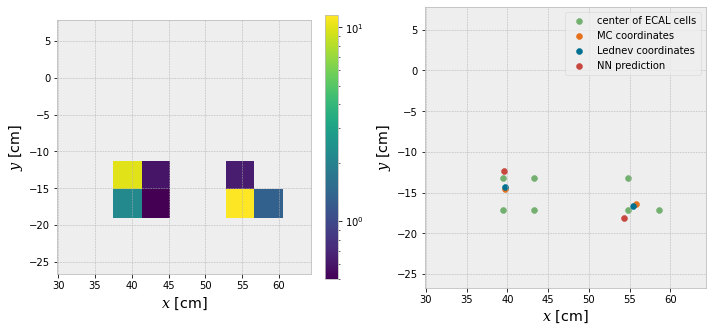

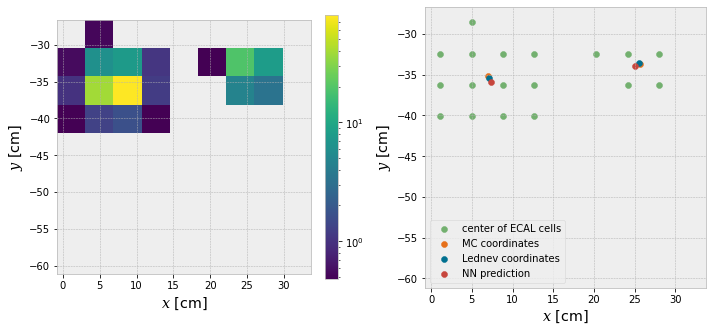

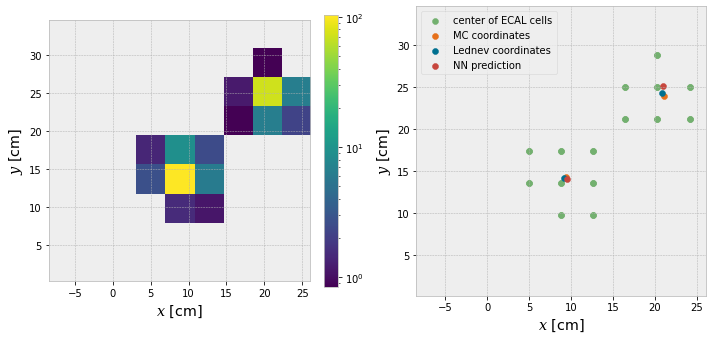

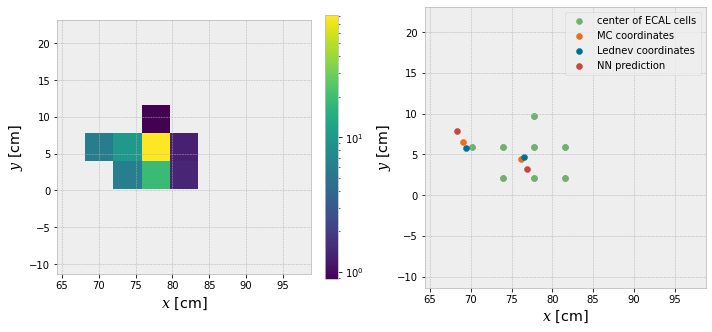

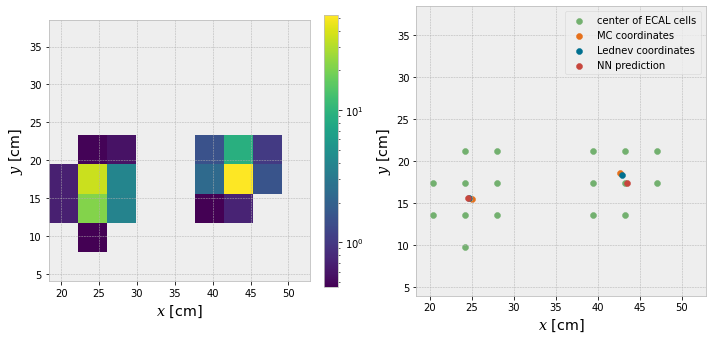

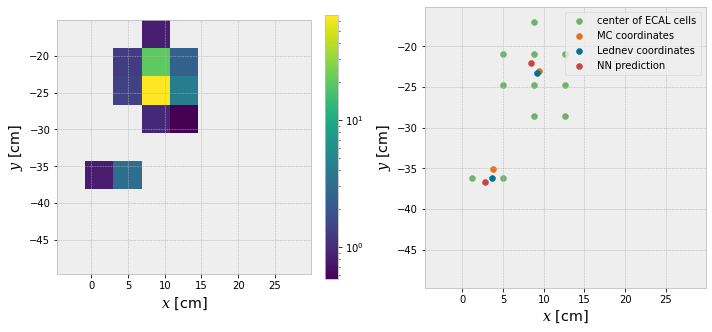

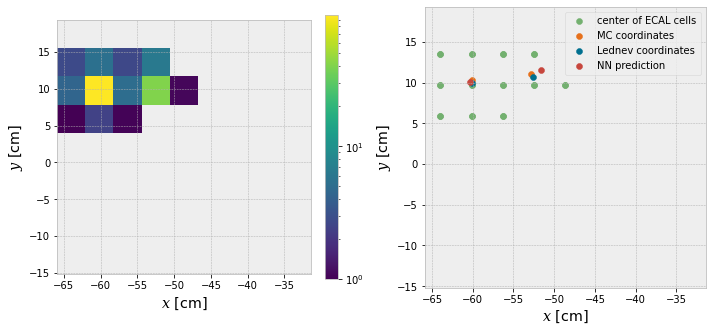

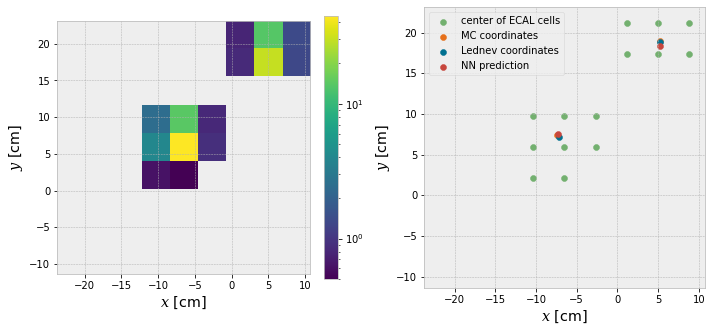

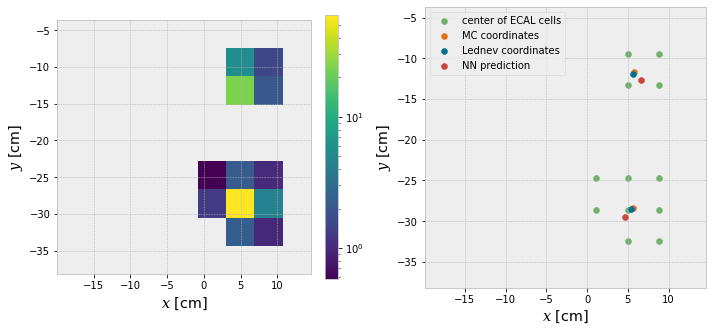

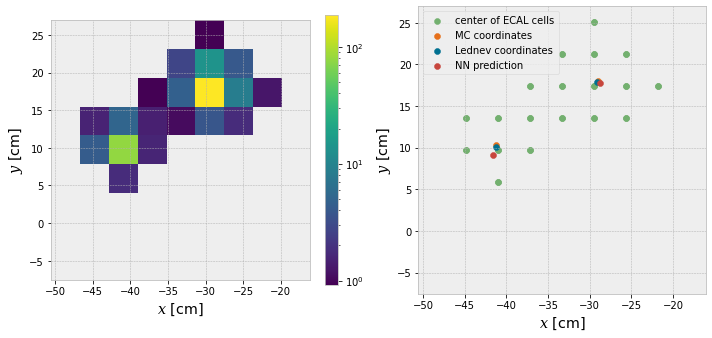

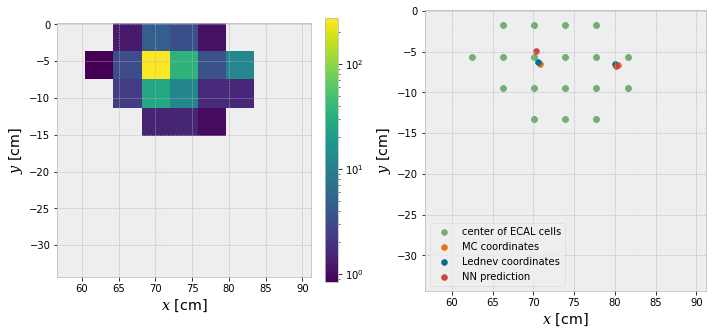

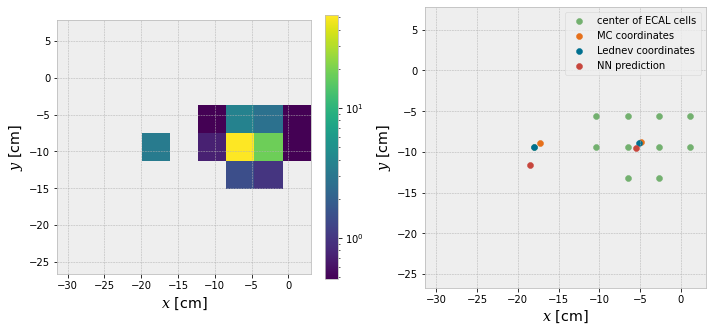

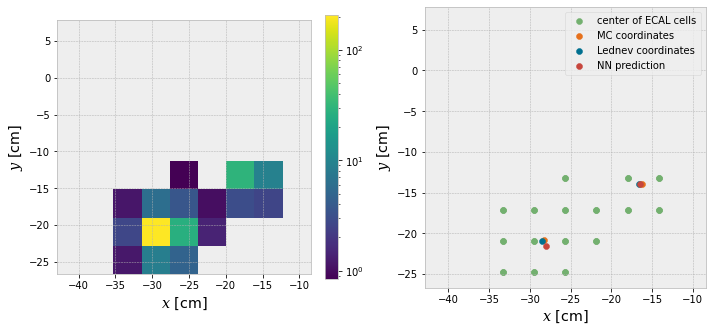

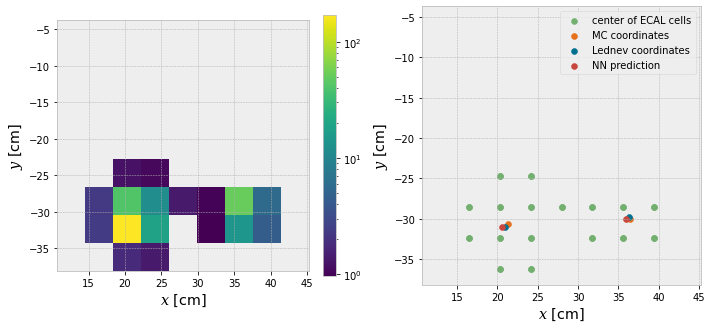

In [13]:
for i in range(100):
    ev1.show_cluster_NNpred(i)

In [14]:
model1.save('models/model_st4_custom_loss_min_dis_4cm_alpha=0.0001')

INFO:tensorflow:Assets written to: models/model_st4_custom_loss_min_dis_4cm_alpha=0.0001/assets


Well this looks all right, but why is the position so badly learned?

Code unten ist falsch!!! Keine implementierung von 1 und 2 und außerdem NICHT relative abweichung fuer x betrachten!!!

In [17]:
def gaus(x, mu, sigma, A):
    return (A/np.sqrt(2*np.pi * sigma**2))* np.exp(-(x-mu)**2 / (2*sigma**2))

def histo_output_relxy_new(xy_NN, xy_truth, E_truth, theta_z_v, theta_x_v, theta_y_v, name='', range_x = (-0.25,0.25), bins=300, num_sig=1):
    '''similar to histo_output but written for x/y to display relative difference and return values that are more than "num_sig" times sigma away and their corresponding engery'''
    
    plt.rcParams["figure.figsize"] = (5,3)
    plt.subplot(1,1,1)
    n_counts, bins, patches = plt.hist((xy_NN-xy_truth)/xy_truth, bins=bins, range=range_x)

    x_centers = 0.5*(bins[:-1]+bins[1:])
    popt1, pcov1 = curve_fit(gaus, x_centers, n_counts, p0=[0,1, 100], sigma=1/np.sqrt(n_counts), maxfev=10000)
    perr1 = np.sqrt(np.diag(pcov1))
    x_fit = np.linspace(x_centers[0], x_centers[-1], 500)
    y_fit = gaus(x_fit, *popt1)
    plt.plot(x_fit, y_fit, 'r--', label="Gaussian fit with " + r"$\mu = ({:.4f} \pm {:.4f})$".format(popt1[0], perr1[0]) + ", " + r"$\sigma = ({:.4f} \pm {:.4f})$".format(popt1[1], perr1[1]))
    plt.legend()
    plt.xlabel("relative difference of true and predicted value of " + name)
    plt.ylabel("counts")

    # which values does NN not learn correctly (energy)?
    ind_bad = np.where(abs((xy_NN-xy_truth)/xy_truth) > num_sig * abs(popt1[1])) # all events further away than 1 sigma
    print("Bad indicies: ", len(ind_bad[0]))
    print("All: ", len(xy_truth))
    values_bad_xy = xy_truth[ind_bad]
    E_bad = E_truth[ind_bad]
    theta_zbad = theta_z_v[ind_bad]
    theta_xbad = theta_x_v[ind_bad]
    theta_ybad = theta_y_v[ind_bad]
    
    plt.tight_layout()
    plt.show()
    
    return values_bad_xy, E_bad, theta_zbad, theta_xbad, theta_ybad # return values that are more than 1 (num_sig) sigma away

In [20]:
theta_x_t = np.arccos(ipd.momentum_t.T[0]/ (np.linalg.norm(ipd.momentum_t, axis=1)))
theta_y_t = np.arccos(ipd.momentum_t.T[1]/ (np.linalg.norm(ipd.momentum_t, axis=1)))
theta_z_t = np.arccos(ipd.momentum_t.T[2]/ (np.linalg.norm(ipd.momentum_t, axis=1)))
theta_x_v = np.arccos(ipd.momentum_v.T[0]/ (np.linalg.norm(ipd.momentum_v, axis=1)))
theta_y_v = np.arccos(ipd.momentum_v.T[1]/ (np.linalg.norm(ipd.momentum_v, axis=1)))
theta_z_v = np.arccos(ipd.momentum_v.T[2]/ (np.linalg.norm(ipd.momentum_v, axis=1)))

Bad indicies:  41263
All:  89821


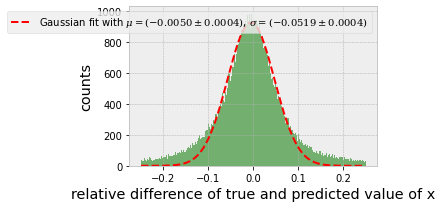

Bad indicies:  41009
All:  89821


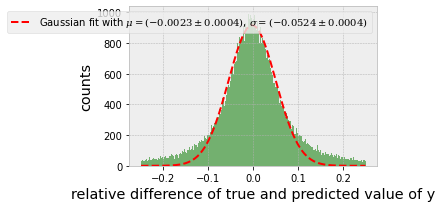

In [21]:
x_bad, Ex_bad, theta_z_xbad, theta_x_xbad, theta_y_xbad = histo_output_relxy_new(output1.T[0], ipd.veri_truth.T[0], ipd.veri_truth.T[2], theta_z_v, theta_x_v, theta_y_v, name='x')
y_bad, Ey_bad, theta_z_ybad, theta_x_ybad, theta_y_ybad = histo_output_relxy_new(output1.T[1], ipd.veri_truth.T[1], ipd.veri_truth.T[2], theta_z_v, theta_x_v, theta_y_v, name='y')


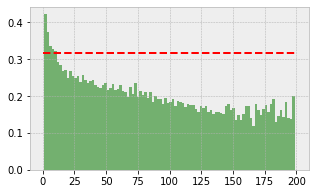

In [22]:
hist_Ex_bad, bin_Ex_bad = np.histogram(Ex_bad, bins=100)
hist_E_veri, bin_E_veri = np.histogram(ipd.E_truth_veri, bins=100)
plt.bar(bin_E_veri[:len(bin_E_veri)-1], hist_Ex_bad/hist_E_veri, align='edge', width=bin_E_veri[1]-bin_E_veri[0]) # aligned mit linker Ecke von edge
plt.hlines(0.3173, 0, 200,  'r', linestyles="dashed")

/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


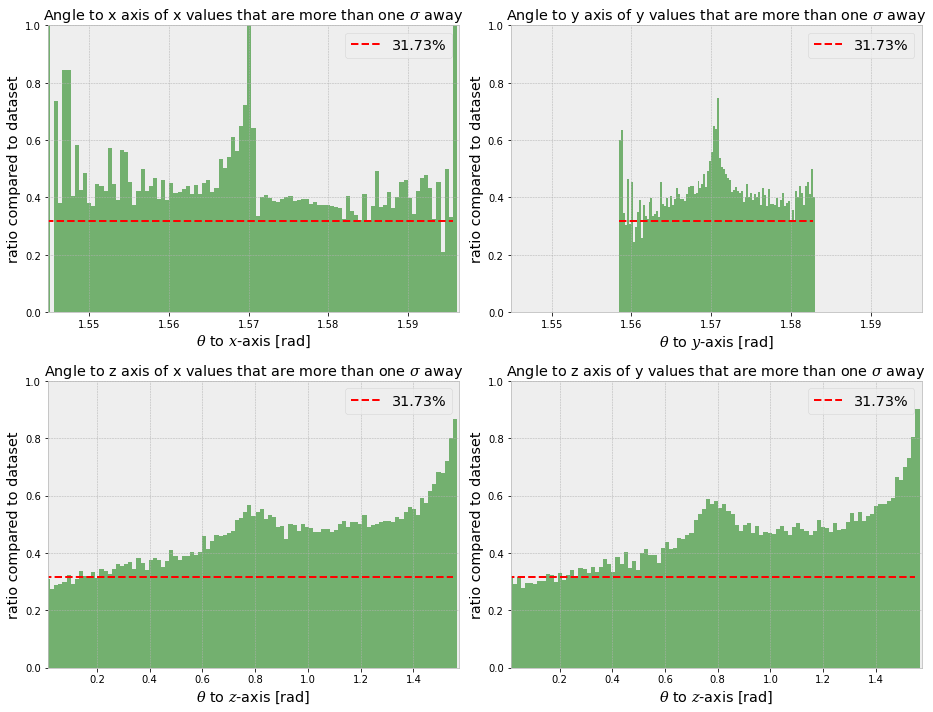

In [24]:
plt.rcParams["figure.figsize"] = (13,10) #(12,12)

ylim = 1
hist_theta_x_veri, bin_theta_x_veri = np.histogram(theta_x_v, bins=100)
hist_theta_y_veri, bin_theta_y_veri = np.histogram(theta_y_v, bins=100)
hist_theta_z_veri, bin_theta_z_veri = np.histogram(theta_z_v, bins=100)

plt.subplot(2,2,1)

hist_theta_x_xbad, bin_theta_x_xbad = np.histogram(theta_x_xbad, bins=100)
plt.bar(bin_theta_x_veri[:len(bin_theta_x_veri)-1], hist_theta_x_xbad/hist_theta_x_veri, align='edge', width=bin_theta_x_veri[1]-bin_theta_x_veri[0]) # aligned mit linker Ecke von edge
plt.hlines(0.3173, bin_theta_x_veri[0], bin_theta_x_veri[-2],  'r', linestyles="dashed", label="31.73%")
plt.legend(fontsize="x-large")
plt.title("Angle to x axis of x values that are more than one $\sigma$ away ")
plt.xlabel(r"$\theta$ to $x$-axis [rad]")
plt.ylabel("ratio compared to dataset")
plt.ylim(0, ylim)
plt.xlim(bin_theta_x_veri[0]+(bin_theta_x_veri[1]-bin_theta_x_veri[0])/2, bin_theta_x_veri[-1]+(bin_theta_x_veri[1]-bin_theta_x_veri[0])/2)

plt.subplot(2,2,2)

hist_theta_y_ybad, bin_theta_y_ybad = np.histogram(theta_y_ybad, bins=100)
plt.bar(bin_theta_y_veri[:len(bin_theta_y_veri)-1], hist_theta_y_ybad/hist_theta_y_veri, align='edge', width=bin_theta_y_veri[1]-bin_theta_y_veri[0]) # aligned mit linker Ecke von edge
plt.hlines(0.3173, bin_theta_y_veri[0], bin_theta_y_veri[-2],  'r', linestyles="dashed", label="31.73%")
plt.legend(fontsize="x-large")
plt.title("Angle to y axis of y values that are more than one $\sigma$ away ")
plt.xlabel(r"$\theta$ to $y$-axis [rad]")
plt.ylabel("ratio compared to dataset")
plt.ylim(0, ylim)
plt.xlim(bin_theta_x_veri[0]+(bin_theta_x_veri[1]-bin_theta_x_veri[0])/2, bin_theta_x_veri[-1]+(bin_theta_x_veri[1]-bin_theta_x_veri[0])/2)


plt.subplot(2,2,3)


hist_theta_z_xbad, bin_theta_z_xbad = np.histogram(theta_z_xbad, bins=100)
plt.bar(bin_theta_z_veri[:len(bin_theta_z_veri)-1], hist_theta_z_xbad/hist_theta_z_veri, align='edge', width=bin_theta_z_veri[1]-bin_theta_z_veri[0]) # aligned mit linker Ecke von edge
plt.hlines(0.3173, 0, bin_theta_z_veri[-2],  'r', linestyles="dashed", label="31.73%")
plt.legend(fontsize="x-large")
plt.title("Angle to z axis of x values that are more than one $\sigma$ away ")
plt.xlabel(r"$\theta$ to $z$-axis [rad]")
plt.ylabel("ratio compared to dataset")
plt.ylim(0, ylim)
plt.xlim(bin_theta_z_veri[0]+(bin_theta_z_veri[1]-bin_theta_z_veri[0])/2, bin_theta_z_veri[-1]+(bin_theta_z_veri[1]-bin_theta_z_veri[0])/2)


plt.subplot(2,2,4)

hist_theta_z_ybad, bin_theta_z_ybad = np.histogram(theta_z_ybad, bins=100)
plt.bar(bin_theta_z_veri[:len(bin_theta_z_veri)-1], hist_theta_z_ybad/hist_theta_z_veri, align='edge', width=bin_theta_z_veri[1]-bin_theta_z_veri[0]) # aligned mit linker Ecke von edge
plt.hlines(0.3173, 0, bin_theta_z_veri[-2],  'r', linestyles="dashed", label="31.73%")
plt.legend(fontsize="x-large")
plt.title("Angle to z axis of y values that are more than one $\sigma$ away ")
plt.xlabel(r"$\theta$ to $z$-axis [rad]")
plt.ylabel("ratio compared to dataset")
plt.ylim(0, ylim)
plt.xlim(bin_theta_z_veri[0]+(bin_theta_z_veri[1]-bin_theta_z_veri[0])/2, bin_theta_z_veri[-1]+(bin_theta_z_veri[1]-bin_theta_z_veri[0])/2)



plt.tight_layout()
plt.show()